# Long-Horizon Eco-Climate–Urban Simulations

This notebook implements a family of reduced-form Earth system simulations designed to explore global climate trajectories over multi-century horizons under coupled ecological, atmospheric, and built-environment dynamics. The models are intentionally simplified, not to produce precise forecasts, but to expose causal structure, feedback timing, and policy-sensitive pathways that are often obscured in large integrated assessment or general circulation models.

At the core of the simulations is a two-layer energy-balance climate model, in which a well-mixed surface layer exchanges heat with a deep ocean reservoir while responding to radiative forcing from greenhouse gases and anthropogenic surface modifications. Atmospheric carbon dioxide evolves dynamically through emissions, ocean uptake, slow atmospheric removal, and an explicit terrestrial biosphere model that tracks vegetation and soil carbon stocks. Land carbon fluxes respond nonlinearly to temperature, carbon dioxide concentration, and land availability, allowing the land system to transition endogenously between sink and source regimes.

Beyond CO₂, the framework includes long-lived trace gases with uncertain lifetimes, exemplified by nitrous oxide, whose atmospheric burden depends on time-varying stratospheric loss rates. This allows the simulations to represent uncertainty arising from chemical–dynamical feedbacks rather than treating trace-gas forcing as exogenous.

A central focus of the notebook is the built environment. Urbanization and road coverage are treated as explicit historical trajectories rather than static background conditions. These trajectories influence climate in two distinct ways. First, they generate an additional global-mean forcing term representing urban heat island and built-surface effects, whose magnitude depends on the extent of cities and roads and is amplified under warmer background climates. Second, expansion of impervious surfaces reduces the effective land area available for biological productivity and soil carbon storage, weakening terrestrial carbon uptake and introducing a structural coupling between infrastructure policy and atmospheric CO₂.

The simulations are run over time spans of up to six hundred years to capture slow ocean adjustment, long carbon residence times, and delayed ecological responses. Policy scenarios are represented not as discrete “worlds,” but as differences in the timing and rate of urban and road expansion, the degree of mitigation applied to built surfaces, and the extent of land restoration or depaving. By varying these inputs, the notebook explores how early or rapid infrastructure takeoff can lock in long-term climate and carbon outcomes even when emissions trajectories are similar.

The intent of this notebook is exploratory and pedagogical. All components are transparent, state-based, and directly modifiable, enabling sensitivity analysis and conceptual experiments rather than definitive prediction. The structure is designed to make explicit where assumptions enter, how feedbacks compound over centuries, and which levers—ecological, chemical, or infrastructural—most strongly shape long-term climate behavior.


In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def simulate_ecoclimate(
    years=600,
    dt=1/12,  # years; monthly timestep
    # Emissions scenario (GtCO2/yr, user can swap this out)
    emissions_func=None,
    # Carbon cycle parameters
    C0_ppm=280.0,          # preindustrial CO2 (ppm)
    C_init_ppm=420.0,      # initial CO2 (ppm)
    airborne_base=0.45,    # baseline airborne fraction (unitless, effective)
    tau_atm=120.0,         # effective atmospheric CO2 removal timescale (years)
    # Ecological land sink feedback (very simple)
    land_sink_0=2.5,       # baseline land sink at reference state (GtCO2/yr)
    beta_CO2=0.25,         # CO2 fertilization strength (dimensionless-ish)
    gamma_T=0.04,          # warming reduces land sink (1/°C, fraction per °C)
    # Ocean sink (very simple linear uptake)
    ocean_sink_0=2.3,      # baseline ocean sink at reference state (GtCO2/yr)
    ocean_k=0.015,         # sensitivity of ocean sink to CO2 anomaly (1/ppm)
    ocean_T_supp=0.02,     # warming suppresses ocean uptake (1/°C, fraction per °C)
    # Climate forcing parameters
    F2x=3.7,               # W/m^2 forcing for CO2 doubling
    F_other=0.0,           # W/m^2 constant non-CO2 forcing; keep 0 unless you want it
    # Two-box energy balance model parameters
    C_m=8.0,               # W·yr/m^2/°C mixed layer heat capacity (~ 50–100 m)
    C_d=100.0,             # W·yr/m^2/°C deep ocean effective heat capacity
    lambda_clim=1.1,       # W/m^2/°C climate feedback parameter (sets ECS with F2x)
    kappa=0.65,            # W/m^2/°C ocean heat exchange (mixed->deep)
    # Temperature initial conditions
    Tm0=0.0,               # °C anomaly relative to reference
    Td0=0.0
):
    if emissions_func is None:
        # Default: a smooth "peak then decline" emissions path (GtCO2/yr)
        def emissions_func(t_year):
            # t_year in years from start
            peak = 40.0
            t_peak = 20.0
            decline_tau = 60.0
            if t_year <= t_peak:
                return peak * (t_year / t_peak)
            else:
                return peak * np.exp(-(t_year - t_peak)/decline_tau)
    
    # Unit conversions
    # 1 ppm CO2 ~ 2.12 GtC, and 1 GtC = 3.667 GtCO2, so 1 ppm ~ 7.77 GtCO2
    ppm_to_GtCO2 = 7.77
    GtCO2_to_ppm = 1.0 / ppm_to_GtCO2
    
    n = int(years / dt) + 1
    t = np.linspace(0, years, n)
    
    C_ppm = np.zeros(n)
    Tm = np.zeros(n)
    Td = np.zeros(n)
    E = np.zeros(n)
    land_sink = np.zeros(n)
    ocean_sink = np.zeros(n)
    F = np.zeros(n)
    
    C_ppm[0] = C_init_ppm
    Tm[0] = Tm0
    Td[0] = Td0
    
    # Reference sinks at reference state (C0, T=0)
    for i in range(n-1):
        ti = t[i]
        Ei = emissions_func(ti)
        E[i] = Ei
        
        # Carbon anomaly relative to preindustrial
        dC = C_ppm[i] - C0_ppm
        
        # Very simple ecological land sink model:
        # baseline sink scaled up by CO2 fertilization and scaled down by warming stress
        fert = 1.0 + beta_CO2 * np.log(max(C_ppm[i], 1e-6) / C0_ppm)
        heat_stress = max(0.0, 1.0 - gamma_T * max(Tm[i], 0.0))
        land_i = land_sink_0 * fert * heat_stress
        
        # Very simple ocean sink model:
        # baseline plus linear dependence on CO2 anomaly, suppressed by warming
        warm_supp = max(0.0, 1.0 - ocean_T_supp * max(Tm[i], 0.0))
        ocean_i = (ocean_sink_0 + (ocean_k * dC * ppm_to_GtCO2)) * warm_supp
        
        land_sink[i] = land_i
        ocean_sink[i] = ocean_i
        
        # Atmospheric removal as a leaky integrator (effective timescale)
        # Here we treat "tau_atm" as additional slow removal beyond explicit sinks.
        leak = (dC * ppm_to_GtCO2) / tau_atm  # GtCO2/yr
        
        # Net change in atmospheric CO2 mass (GtCO2/yr)
        dM_atm = airborne_base * Ei - land_i - ocean_i - leak
        
        # Update CO2 in ppm
        C_ppm[i+1] = max(1e-6, C_ppm[i] + (dM_atm * GtCO2_to_ppm) * dt)
        
        # Radiative forcing (CO2 log forcing)
        F_co2 = F2x * np.log(C_ppm[i] / C0_ppm) / np.log(2.0)
        F[i] = F_co2 + F_other
        
        # Two-box EBM:
        # C_m dTm/dt = F - lambda Tm - kappa (Tm - Td)
        # C_d dTd/dt = kappa (Tm - Td)
        dTm = (F[i] - lambda_clim * Tm[i] - kappa * (Tm[i] - Td[i])) / C_m
        dTd = (kappa * (Tm[i] - Td[i])) / C_d
        
        Tm[i+1] = Tm[i] + dTm * dt
        Td[i+1] = Td[i] + dTd * dt
    
    # Fill last-step diagnostics
    E[-1] = emissions_func(t[-1])
    dC = C_ppm[-1] - C0_ppm
    fert = 1.0 + beta_CO2 * np.log(max(C_ppm[-1], 1e-6) / C0_ppm)
    heat_stress = max(0.0, 1.0 - gamma_T * max(Tm[-1], 0.0))
    land_sink[-1] = land_sink_0 * fert * heat_stress
    warm_supp = max(0.0, 1.0 - ocean_T_supp * max(Tm[-1], 0.0))
    ocean_sink[-1] = (ocean_sink_0 + (ocean_k * dC * ppm_to_GtCO2)) * warm_supp
    F[-1] = F2x * np.log(C_ppm[-1] / C0_ppm) / np.log(2.0) + F_other
    
    return {
        "t_years": t,
        "CO2_ppm": C_ppm,
        "T_mixed_C": Tm,
        "T_deep_C": Td,
        "Emissions_GtCO2yr": E,
        "LandSink_GtCO2yr": land_sink,
        "OceanSink_GtCO2yr": ocean_sink,
        "Forcing_Wm2": F
    }

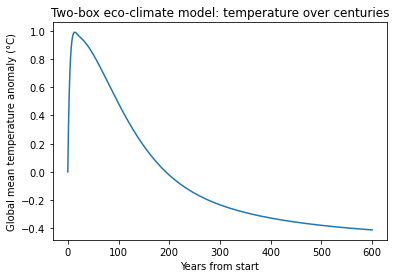

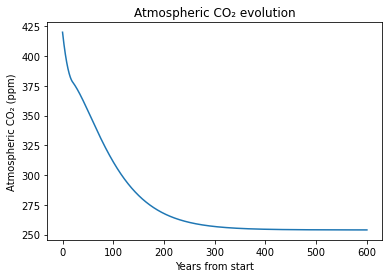

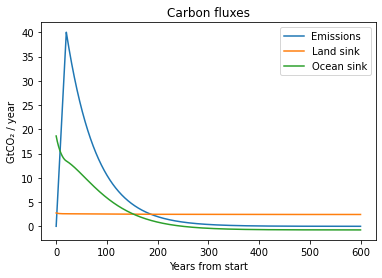

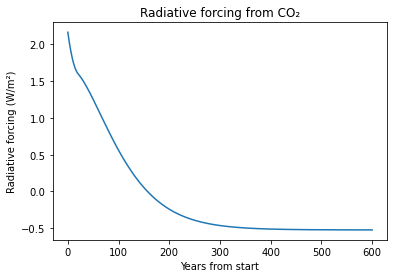

In [3]:
out = simulate_ecoclimate(years=600, dt=1/12)

t = out["t_years"]
CO2 = out["CO2_ppm"]
Tm = out["T_mixed_C"]
E = out["Emissions_GtCO2yr"]
Ls = out["LandSink_GtCO2yr"]
Os = out["OceanSink_GtCO2yr"]
F = out["Forcing_Wm2"]

plt.figure()
plt.plot(t, Tm)
plt.xlabel("Years from start")
plt.ylabel("Global mean temperature anomaly (°C)")
plt.title("Two-box eco-climate model: temperature over centuries")
plt.show()

plt.figure()
plt.plot(t, CO2)
plt.xlabel("Years from start")
plt.ylabel("Atmospheric CO₂ (ppm)")
plt.title("Atmospheric CO₂ evolution")
plt.show()

plt.figure()
plt.plot(t, E, label="Emissions")
plt.plot(t, Ls, label="Land sink")
plt.plot(t, Os, label="Ocean sink")
plt.xlabel("Years from start")
plt.ylabel("GtCO₂ / year")
plt.title("Carbon fluxes")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, F)
plt.xlabel("Years from start")
plt.ylabel("Radiative forcing (W/m²)")
plt.title("Radiative forcing from CO₂")
plt.show()


In [4]:
def n2o_lifetime_years(t_year, tau0=117.0, trend_pct_per_decade=-1.4, 
                      feedback_strength=-0.065, N_ref_ppb=330.0, N_ppb=None, 
                      use_feedback=False):
    """
    tau(t) = tau0 * exp( trend * t ) with trend specified in % per decade.
    If use_feedback=True and N_ppb provided, apply a multiplicative burden feedback:
    d ln tau / d ln N = feedback_strength (typically negative).
    """
    trend_per_year = (trend_pct_per_decade / 100.0) / 10.0
    tau_t = tau0 * np.exp(trend_per_year * t_year)

    if use_feedback and (N_ppb is not None):
        tau_t = tau_t * (max(N_ppb, 1e-9) / N_ref_ppb) ** (feedback_strength)

    return tau_t


In [5]:
def simulate_ecoclimate_with_n2o(
    years=600,
    dt=1/12,
    # CO2 emissions as before (GtCO2/yr)
    emissions_CO2_func=None,
    # N2O emissions (TgN/yr). 1 TgN/yr is a plausible order-of-magnitude scale.
    emissions_N2O_func=None,

    # --- CO2 / climate core (same meanings as earlier) ---
    C0_ppm=280.0,
    C_init_ppm=420.0,
    airborne_base=0.45,
    tau_atm=120.0,
    land_sink_0=2.5,
    beta_CO2=0.25,
    gamma_T=0.04,
    ocean_sink_0=2.3,
    ocean_k=0.015,
    ocean_T_supp=0.02,
    F2x=3.7,
    F_other=0.0,
    C_m=8.0,
    C_d=100.0,
    lambda_clim=1.1,
    kappa=0.65,
    Tm0=0.0,
    Td0=0.0,

    # --- N2O module ---
    N0_ppb=270.0,          # preindustrial-ish N2O (ppb)
    N_init_ppb=337.0,      # around recent value (paper mentions ~337 ppb in 2024)
    tauN0_years=117.0,     # baseline lifetime
    tauN_trend_pct_decade=-1.4,   # lifetime trend (%/decade), negative means shorter lifetime over time
    use_tau_feedback=True,
    tau_feedback_strength=-0.065, # d ln tau / d ln N
    N_ref_ppb=330.0,
    # N2O forcing coefficient (W/m^2 per ppb anomaly). Keep simple; calibrate as you like.
    kN_Wm2_per_ppb=0.003
):
    if emissions_CO2_func is None:
        def emissions_CO2_func(t_year):
            peak = 40.0
            t_peak = 20.0
            decline_tau = 60.0
            if t_year <= t_peak:
                return peak * (t_year / t_peak)
            else:
                return peak * np.exp(-(t_year - t_peak)/decline_tau)

    if emissions_N2O_func is None:
        def emissions_N2O_func(t_year):
            # A smooth “rise then slow decline” in TgN/yr, just as a default toy pathway.
            peak = 14.0
            t_peak = 30.0
            decline_tau = 120.0
            if t_year <= t_peak:
                return peak * (t_year / t_peak)
            else:
                return peak * np.exp(-(t_year - t_peak)/decline_tau)

    ppm_to_GtCO2 = 7.77
    GtCO2_to_ppm = 1.0 / ppm_to_GtCO2

    # N2O burden conversion: ppb <-> TgN.
    # Prather–Wilson note a scaling factor 4.79 TgN/ppb used for burden estimates.
    TgN_per_ppb = 4.79
    ppb_per_TgN = 1.0 / TgN_per_ppb

    n = int(years / dt) + 1
    t = np.linspace(0, years, n)

    CO2_ppm = np.zeros(n)
    N2O_ppb = np.zeros(n)
    Tm = np.zeros(n)
    Td = np.zeros(n)

    E_CO2 = np.zeros(n)
    E_N2O = np.zeros(n)
    land_sink = np.zeros(n)
    ocean_sink = np.zeros(n)
    tauN = np.zeros(n)

    F_co2 = np.zeros(n)
    F_n2o = np.zeros(n)
    F_total = np.zeros(n)

    CO2_ppm[0] = C_init_ppm
    N2O_ppb[0] = N_init_ppb
    Tm[0] = Tm0
    Td[0] = Td0

    for i in range(n-1):
        ti = t[i]

        # Emissions
        E_CO2[i] = emissions_CO2_func(ti)
        E_N2O[i] = emissions_N2O_func(ti)

        # --- CO2 sinks (same structure as earlier) ---
        dC = CO2_ppm[i] - C0_ppm

        fert = 1.0 + beta_CO2 * np.log(max(CO2_ppm[i], 1e-6) / C0_ppm)
        heat_stress = max(0.0, 1.0 - gamma_T * max(Tm[i], 0.0))
        land_i = land_sink_0 * fert * heat_stress

        warm_supp = max(0.0, 1.0 - ocean_T_supp * max(Tm[i], 0.0))
        ocean_i = (ocean_sink_0 + (ocean_k * dC * ppm_to_GtCO2)) * warm_supp

        land_sink[i] = land_i
        ocean_sink[i] = ocean_i

        leak = (dC * ppm_to_GtCO2) / tau_atm

        dM_atm = airborne_base * E_CO2[i] - land_i - ocean_i - leak
        CO2_ppm[i+1] = max(1e-6, CO2_ppm[i] + (dM_atm * GtCO2_to_ppm) * dt)

        # --- N2O evolution with time-varying lifetime and optional burden feedback ---
        tauN[i] = n2o_lifetime_years(
            ti,
            tau0=tauN0_years,
            trend_pct_per_decade=tauN_trend_pct_decade,
            feedback_strength=tau_feedback_strength,
            N_ref_ppb=N_ref_ppb,
            N_ppb=N2O_ppb[i],
            use_feedback=use_tau_feedback
        )

        # d(N burden)/dt = emissions - burden/tau
        N_burden_TgN = N2O_ppb[i] * TgN_per_ppb
        dN_burden = E_N2O[i] - (N_burden_TgN / tauN[i])
        N_burden_TgN_next = max(0.0, N_burden_TgN + dN_burden * dt)
        N2O_ppb[i+1] = N_burden_TgN_next * ppb_per_TgN

        # --- Forcing ---
        F_co2[i] = F2x * np.log(CO2_ppm[i] / C0_ppm) / np.log(2.0)
        F_n2o[i] = kN_Wm2_per_ppb * (N2O_ppb[i] - N0_ppb)
        F_total[i] = F_co2[i] + F_n2o[i] + F_other

        # --- Two-box temperature response ---
        dTm = (F_total[i] - lambda_clim * Tm[i] - kappa * (Tm[i] - Td[i])) / C_m
        dTd = (kappa * (Tm[i] - Td[i])) / C_d

        Tm[i+1] = Tm[i] + dTm * dt
        Td[i+1] = Td[i] + dTd * dt

    # Fill last-step forcing/lifetime arrays
    tauN[-1] = n2o_lifetime_years(
        t[-1],
        tau0=tauN0_years,
        trend_pct_per_decade=tauN_trend_pct_decade,
        feedback_strength=tau_feedback_strength,
        N_ref_ppb=N_ref_ppb,
        N_ppb=N2O_ppb[-1],
        use_feedback=use_tau_feedback
    )
    F_co2[-1] = F2x * np.log(CO2_ppm[-1] / C0_ppm) / np.log(2.0)
    F_n2o[-1] = kN_Wm2_per_ppb * (N2O_ppb[-1] - N0_ppb)
    F_total[-1] = F_co2[-1] + F_n2o[-1] + F_other
    E_CO2[-1] = emissions_CO2_func(t[-1])
    E_N2O[-1] = emissions_N2O_func(t[-1])

    return {
        "t_years": t,
        "CO2_ppm": CO2_ppm,
        "N2O_ppb": N2O_ppb,
        "tauN_years": tauN,
        "T_mixed_C": Tm,
        "T_deep_C": Td,
        "E_CO2_GtCO2yr": E_CO2,
        "E_N2O_TgNyr": E_N2O,
        "LandSink_GtCO2yr": land_sink,
        "OceanSink_GtCO2yr": ocean_sink,
        "F_co2_Wm2": F_co2,
        "F_n2o_Wm2": F_n2o,
        "F_total_Wm2": F_total,
    }


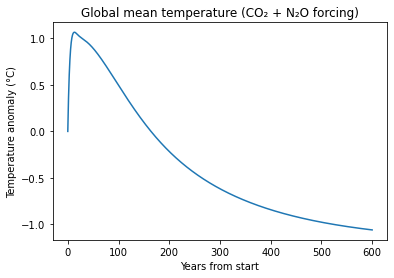

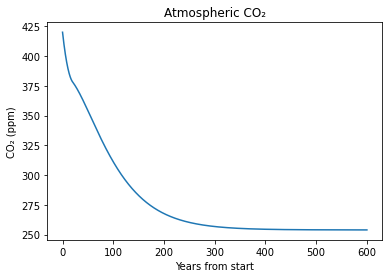

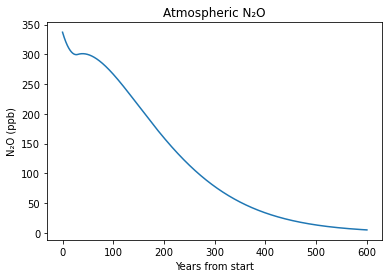

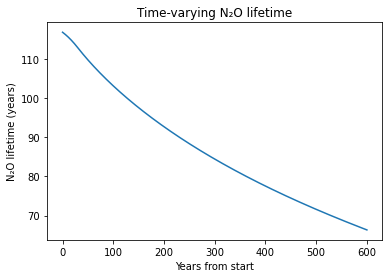

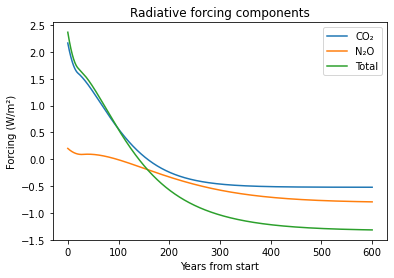

In [6]:
# Baseline run with N2O lifetime trend enabled (default -1.4% per decade)
out2 = simulate_ecoclimate_with_n2o(years=600, dt=1/12)

t = out2["t_years"]
Tm = out2["T_mixed_C"]
CO2 = out2["CO2_ppm"]
N2O = out2["N2O_ppb"]
tauN = out2["tauN_years"]
Fco2 = out2["F_co2_Wm2"]
Fn2o = out2["F_n2o_Wm2"]
Ftot = out2["F_total_Wm2"]

plt.figure()
plt.plot(t, Tm)
plt.xlabel("Years from start")
plt.ylabel("Temperature anomaly (°C)")
plt.title("Global mean temperature (CO₂ + N₂O forcing)")
plt.show()

plt.figure()
plt.plot(t, CO2)
plt.xlabel("Years from start")
plt.ylabel("CO₂ (ppm)")
plt.title("Atmospheric CO₂")
plt.show()

plt.figure()
plt.plot(t, N2O)
plt.xlabel("Years from start")
plt.ylabel("N₂O (ppb)")
plt.title("Atmospheric N₂O")
plt.show()

plt.figure()
plt.plot(t, tauN)
plt.xlabel("Years from start")
plt.ylabel("N₂O lifetime (years)")
plt.title("Time-varying N₂O lifetime")
plt.show()

plt.figure()
plt.plot(t, Fco2, label="CO₂")
plt.plot(t, Fn2o, label="N₂O")
plt.plot(t, Ftot, label="Total")
plt.xlabel("Years from start")
plt.ylabel("Forcing (W/m²)")
plt.title("Radiative forcing components")
plt.legend()
plt.show()


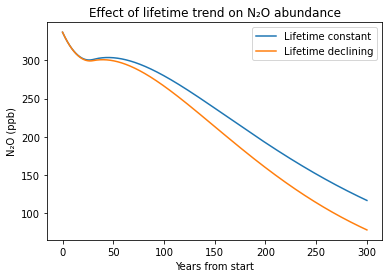

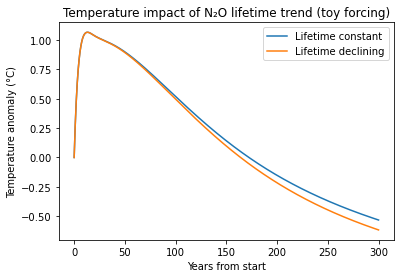

In [7]:
# Comparison cell: turning the N₂O lifetime trend off vs on,
# to isolate the "sink uncertainty" effect on N₂O and temperature.

out_const = simulate_ecoclimate_with_n2o(
    years=300, dt=1/12,
    tauN_trend_pct_decade=0.0,   # constant lifetime
    use_tau_feedback=True
)

out_trend = simulate_ecoclimate_with_n2o(
    years=300, dt=1/12,
    tauN_trend_pct_decade=-1.4,  # declining lifetime
    use_tau_feedback=True
)

t = out_const["t_years"]

plt.figure()
plt.plot(t, out_const["N2O_ppb"], label="Lifetime constant")
plt.plot(t, out_trend["N2O_ppb"], label="Lifetime declining")
plt.xlabel("Years from start")
plt.ylabel("N₂O (ppb)")
plt.title("Effect of lifetime trend on N₂O abundance")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, out_const["T_mixed_C"], label="Lifetime constant")
plt.plot(t, out_trend["T_mixed_C"], label="Lifetime declining")
plt.xlabel("Years from start")
plt.ylabel("Temperature anomaly (°C)")
plt.title("Temperature impact of N₂O lifetime trend (toy forcing)")
plt.legend()
plt.show()


In [8]:
def land_biosphere_fluxes(
    CO2_ppm, T, B, S,
    CO2_ref=280.0,
    B_ref=600.0,     # GtC, rough order
    S_ref=1500.0,    # GtC, rough order
    NPP0=60.0,       # GtC/yr at reference state
    k_turn=0.05,     # 1/yr vegetation turnover to litter/soil
    k_respS=0.02,    # 1/yr soil carbon respiration baseline
    Q10=2.0,
    Tref=0.0,
    CO2_fert_strength=0.35,
    CO2_fert_half_sat=550.0,
    heat_stress_perC=0.02
):
    """
    Returns (NPP, litter_to_soil, soil_resp, net_land_flux_to_atm) in GtC/yr.
    Sign convention: net_land_flux_to_atm > 0 means land is a source to atmosphere.
    """

    # CO2 fertilization: saturating response in ppm-space (toy but stable)
    fert = 1.0 + CO2_fert_strength * (CO2_ppm - CO2_ref) / (CO2_ppm - CO2_ref + CO2_fert_half_sat)

    # Temperature effect on NPP: mild increase then heat stress reduces productivity
    # Keep it simple: linear heat stress penalty on positive anomalies
    heat_penalty = max(0.0, 1.0 - heat_stress_perC * max(T - Tref, 0.0))

    NPP = NPP0 * fert * heat_penalty

    # Vegetation turnover to soil/litter pool (aggregate)
    litter_to_soil = k_turn * B

    # Soil respiration with Q10 temperature sensitivity
    temp_factor = Q10 ** ((T - Tref) / 10.0)
    soil_resp = k_respS * S * temp_factor

    # State tendency (GtC/yr) for bookkeeping outside:
    # dB/dt = NPP - litter_to_soil
    # dS/dt = litter_to_soil - soil_resp
    # Atmosphere exchange is minus net ecosystem uptake:
    # net_land_flux_to_atm = soil_resp - NPP  (since litter is internal transfer)
    net_land_flux_to_atm = soil_resp - NPP

    return NPP, litter_to_soil, soil_resp, net_land_flux_to_atm


In [9]:
def simulate_ecoclimate_dynamic_land(
    years=600,
    dt=1/12,

    emissions_CO2_func=None,  # GtCO2/yr

    # CO2 / ocean sink and atmosphere leak (same spirit as before)
    C0_ppm=280.0,
    C_init_ppm=420.0,
    airborne_base=0.45,
    tau_atm=120.0,
    ocean_sink_0=2.3,     # GtCO2/yr at reference
    ocean_k=0.015,        # 1/ppm sensitivity
    ocean_T_supp=0.02,    # 1/°C fractional suppression

    # Climate core
    F2x=3.7,
    F_other=0.0,
    C_m=8.0,
    C_d=100.0,
    lambda_clim=1.1,
    kappa=0.65,
    Tm0=0.0,
    Td0=0.0,

    # Dynamic land carbon states (GtC)
    B0=600.0,
    S0=1500.0,

    # Land biosphere parameters passed through
    land_params=None
):
    if emissions_CO2_func is None:
        def emissions_CO2_func(t_year):
            peak = 40.0
            t_peak = 20.0
            decline_tau = 60.0
            if t_year <= t_peak:
                return peak * (t_year / t_peak)
            else:
                return peak * np.exp(-(t_year - t_peak)/decline_tau)

    if land_params is None:
        land_params = {}

    ppm_to_GtCO2 = 7.77
    GtCO2_to_ppm = 1.0 / ppm_to_GtCO2

    # Carbon units conversion for land fluxes: GtC <-> GtCO2
    GtCO2_per_GtC = 3.667

    n = int(years / dt) + 1
    t = np.linspace(0, years, n)

    CO2_ppm = np.zeros(n)
    Tm = np.zeros(n)
    Td = np.zeros(n)

    B = np.zeros(n)
    S = np.zeros(n)

    E = np.zeros(n)
    ocean_sink = np.zeros(n)
    leak_sink = np.zeros(n)

    NPP = np.zeros(n)
    soil_resp = np.zeros(n)
    net_land_flux_to_atm_GtCO2 = np.zeros(n)

    F = np.zeros(n)

    CO2_ppm[0] = C_init_ppm
    Tm[0] = Tm0
    Td[0] = Td0
    B[0] = B0
    S[0] = S0

    for i in range(n-1):
        ti = t[i]
        Ei = emissions_CO2_func(ti)
        E[i] = Ei

        # Radiative forcing at current state (use mixed-layer anomaly as "T" for ecology)
        F_co2 = F2x * np.log(CO2_ppm[i] / C0_ppm) / np.log(2.0)
        F[i] = F_co2 + F_other

        # Dynamic land carbon fluxes (GtC/yr, then convert net to GtCO2/yr)
        NPP_i, litter_i, soil_resp_i, net_land_to_atm_GtC = land_biosphere_fluxes(
            CO2_ppm=CO2_ppm[i],
            T=Tm[i],
            B=B[i],
            S=S[i],
            CO2_ref=C0_ppm,
            **land_params
        )
        NPP[i] = NPP_i
        soil_resp[i] = soil_resp_i

        # Update land state variables (GtC)
        dB = (NPP_i - litter_i)
        dS = (litter_i - soil_resp_i)
        B[i+1] = max(0.0, B[i] + dB * dt)
        S[i+1] = max(0.0, S[i] + dS * dt)

        net_land_to_atm_GtCO2 = net_land_to_atm_GtC * GtCO2_per_GtC
        net_land_flux_to_atm_GtCO2[i] = net_land_to_atm_GtCO2

        # Ocean sink (GtCO2/yr), suppressed by warming
        dC = CO2_ppm[i] - C0_ppm
        warm_supp = max(0.0, 1.0 - ocean_T_supp * max(Tm[i], 0.0))
        ocean_i = (ocean_sink_0 + (ocean_k * dC * ppm_to_GtCO2)) * warm_supp
        ocean_sink[i] = ocean_i

        # Additional slow “leak” removal (GtCO2/yr)
        leak_i = (dC * ppm_to_GtCO2) / tau_atm
        leak_sink[i] = leak_i

        # Atmospheric CO2 mass balance (GtCO2/yr)
        # Positive net_land_to_atm adds CO2, negative removes it.
        dM_atm = airborne_base * Ei + net_land_to_atm_GtCO2 - ocean_i - leak_i
        CO2_ppm[i+1] = max(1e-6, CO2_ppm[i] + (dM_atm * GtCO2_to_ppm) * dt)

        # Two-box temperature update
        dTm = (F[i] - lambda_clim * Tm[i] - kappa * (Tm[i] - Td[i])) / C_m
        dTd = (kappa * (Tm[i] - Td[i])) / C_d
        Tm[i+1] = Tm[i] + dTm * dt
        Td[i+1] = Td[i] + dTd * dt

    # fill last diagnostics
    E[-1] = emissions_CO2_func(t[-1])
    F[-1] = F2x * np.log(CO2_ppm[-1] / C0_ppm) / np.log(2.0) + F_other

    return {
        "t_years": t,
        "CO2_ppm": CO2_ppm,
        "T_mixed_C": Tm,
        "T_deep_C": Td,
        "B_veg_GtC": B,
        "S_soil_GtC": S,
        "Emissions_GtCO2yr": E,
        "OceanSink_GtCO2yr": ocean_sink,
        "LeakSink_GtCO2yr": leak_sink,
        "NPP_GtCyr": NPP,
        "SoilResp_GtCyr": soil_resp,
        "NetLandFluxToAtm_GtCO2yr": net_land_flux_to_atm_GtCO2,
        "Forcing_Wm2": F
    }


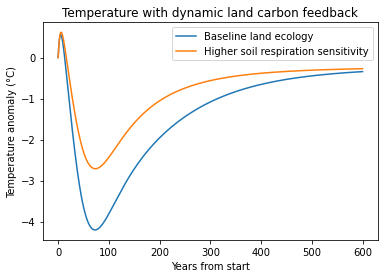

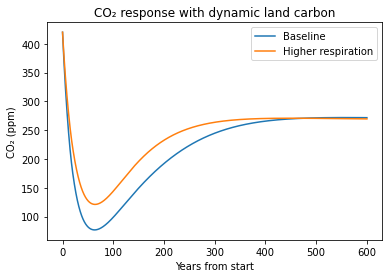

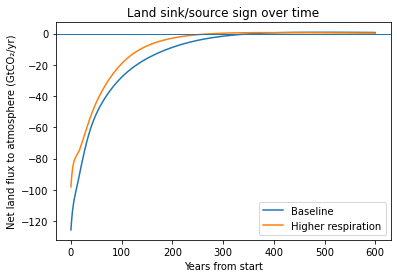

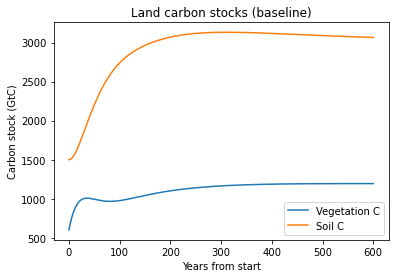

In [10]:
# Run a baseline, then a "hotter respiration" variant to see ecological feedback amplify warming.

baseline = simulate_ecoclimate_dynamic_land(years=600, dt=1/12)

hot_resp = simulate_ecoclimate_dynamic_land(
    years=600, dt=1/12,
    land_params=dict(Q10=2.4, k_respS=0.025)  # stronger soil respiration sensitivity
)

t = baseline["t_years"]

plt.figure()
plt.plot(t, baseline["T_mixed_C"], label="Baseline land ecology")
plt.plot(t, hot_resp["T_mixed_C"], label="Higher soil respiration sensitivity")
plt.xlabel("Years from start")
plt.ylabel("Temperature anomaly (°C)")
plt.title("Temperature with dynamic land carbon feedback")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, baseline["CO2_ppm"], label="Baseline")
plt.plot(t, hot_resp["CO2_ppm"], label="Higher respiration")
plt.xlabel("Years from start")
plt.ylabel("CO₂ (ppm)")
plt.title("CO₂ response with dynamic land carbon")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, baseline["NetLandFluxToAtm_GtCO2yr"], label="Baseline")
plt.plot(t, hot_resp["NetLandFluxToAtm_GtCO2yr"], label="Higher respiration")
plt.axhline(0, linewidth=1)
plt.xlabel("Years from start")
plt.ylabel("Net land flux to atmosphere (GtCO₂/yr)")
plt.title("Land sink/source sign over time")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, baseline["B_veg_GtC"], label="Vegetation C")
plt.plot(t, baseline["S_soil_GtC"], label="Soil C")
plt.xlabel("Years from start")
plt.ylabel("Carbon stock (GtC)")
plt.title("Land carbon stocks (baseline)")
plt.legend()
plt.show()


In [11]:
def logistic_transition(t, y0, y1, t_mid, k):
    """
    Smooth transition from y0 to y1 centered at t_mid with steepness k.
    k has units 1/years. Larger k -> faster change.
    """
    return y0 + (y1 - y0) / (1.0 + np.exp(-k * (t - t_mid)))

def road_urban_trajectories(t_years, scenario):
    """
    Returns (urban_frac, road_frac) as functions of time.
    Fractions are in [0,1] and are "global effective" coverage proxies.

    The scenarios encode different policy futures over ~600 years:
    - "reduce_roads": road fraction declines; urban fraction stabilizes/declines slightly.
    - "slow_growth": slow increase in both.
    - "fast_growth": rapid increase, saturating at higher levels.
    """
    t = np.asarray(t_years)

    if scenario == "reduce_roads":
        u = logistic_transition(t, y0=0.55, y1=0.45, t_mid=120, k=0.015)
        r = logistic_transition(t, y0=0.020, y1=0.010, t_mid=100, k=0.020)

    elif scenario == "slow_growth":
        u = logistic_transition(t, y0=0.55, y1=0.70, t_mid=180, k=0.010)
        r = logistic_transition(t, y0=0.020, y1=0.030, t_mid=220, k=0.010)

    elif scenario == "fast_growth":
        u = logistic_transition(t, y0=0.55, y1=0.85, t_mid=90,  k=0.030)
        r = logistic_transition(t, y0=0.020, y1=0.060, t_mid=100, k=0.030)

    else:
        raise ValueError("Unknown scenario. Use: reduce_roads, slow_growth, fast_growth")

    u = np.clip(u, 0.0, 1.0)
    r = np.clip(r, 0.0, 1.0)
    return u, r


In [12]:
def uhi_forcing_Wm2(urban_frac, road_frac, Tm,
                   alpha_u=0.25, alpha_r=2.5,
                   Tref=0.0, heat_amplify_perC=0.06,
                   mitigation=0.0):
    """
    Toy global-mean forcing from Urban Heat Island + built-surface effects.

    F_uhi = (alpha_u * u + alpha_r * r) * (1 + heat_amplify_perC * max(Tm - Tref, 0)) * (1 - mitigation)

    Interpreting parameters:
    alpha_u: W/m^2 per unit global urban fraction proxy
    alpha_r: W/m^2 per unit global road fraction proxy (roads punch above their area via albedo/thermal mass)
    mitigation: 0..1 policy factor representing reflective materials, greening, shading, district cooling, etc.
    """
    base = alpha_u * np.asarray(urban_frac) + alpha_r * np.asarray(road_frac)
    amplify = 1.0 + heat_amplify_perC * np.maximum(np.asarray(Tm) - Tref, 0.0)
    return base * amplify * (1.0 - np.clip(mitigation, 0.0, 1.0))


In [13]:
def simulate_ecoclimate_dynamic_land_with_uhi(
    years=600,
    dt=1/12,
    scenario="slow_growth",
    mitigation=0.0,

    emissions_CO2_func=None,

    # CO2 / ocean / leak parameters
    C0_ppm=280.0,
    C_init_ppm=420.0,
    airborne_base=0.45,
    tau_atm=120.0,
    ocean_sink_0=2.3,
    ocean_k=0.015,
    ocean_T_supp=0.02,

    # Climate core
    F2x=3.7,
    F_nonCO2_constant=0.0,
    C_m=8.0,
    C_d=100.0,
    lambda_clim=1.1,
    kappa=0.65,
    Tm0=0.0,
    Td0=0.0,

    # Dynamic land carbon
    B0=600.0,
    S0=1500.0,
    land_params=None,

    # UHI forcing parameters
    alpha_u=0.25,
    alpha_r=2.5,
    heat_amplify_perC=0.06,
):
    if emissions_CO2_func is None:
        def emissions_CO2_func(t_year):
            peak = 40.0
            t_peak = 20.0
            decline_tau = 60.0
            if t_year <= t_peak:
                return peak * (t_year / t_peak)
            else:
                return peak * np.exp(-(t_year - t_peak)/decline_tau)

    if land_params is None:
        land_params = {}

    ppm_to_GtCO2 = 7.77
    GtCO2_to_ppm = 1.0 / ppm_to_GtCO2
    GtCO2_per_GtC = 3.667

    n = int(years / dt) + 1
    t = np.linspace(0, years, n)

    # Trajectories for urban/road fractions over the full horizon
    urban_frac, road_frac = road_urban_trajectories(t, scenario=scenario)

    CO2_ppm = np.zeros(n)
    Tm = np.zeros(n)
    Td = np.zeros(n)
    B = np.zeros(n)
    S = np.zeros(n)

    E = np.zeros(n)
    ocean_sink = np.zeros(n)
    leak_sink = np.zeros(n)
    net_land_flux_to_atm_GtCO2 = np.zeros(n)

    F_co2 = np.zeros(n)
    F_uhi = np.zeros(n)
    F_total = np.zeros(n)

    CO2_ppm[0] = C_init_ppm
    Tm[0] = Tm0
    Td[0] = Td0
    B[0] = B0
    S[0] = S0

    for i in range(n-1):
        ti = t[i]
        E[i] = emissions_CO2_func(ti)

        # CO2 forcing
        F_co2[i] = F2x * np.log(CO2_ppm[i] / C0_ppm) / np.log(2.0)

        # Land biosphere fluxes (GtC/yr)
        NPP_i, litter_i, soil_resp_i, net_land_to_atm_GtC = land_biosphere_fluxes(
            CO2_ppm=CO2_ppm[i],
            T=Tm[i],
            B=B[i],
            S=S[i],
            CO2_ref=C0_ppm,
            **land_params
        )

        # Update land stocks (GtC)
        B[i+1] = max(0.0, B[i] + (NPP_i - litter_i) * dt)
        S[i+1] = max(0.0, S[i] + (litter_i - soil_resp_i) * dt)

        net_land_flux_to_atm_GtCO2[i] = net_land_to_atm_GtC * GtCO2_per_GtC

        # Ocean sink and slow leak
        dC = CO2_ppm[i] - C0_ppm
        warm_supp = max(0.0, 1.0 - ocean_T_supp * max(Tm[i], 0.0))
        ocean_i = (ocean_sink_0 + (ocean_k * dC * ppm_to_GtCO2)) * warm_supp
        ocean_sink[i] = ocean_i

        leak_i = (dC * ppm_to_GtCO2) / tau_atm
        leak_sink[i] = leak_i

        # Update atmospheric CO2 (GtCO2/yr balance)
        dM_atm = airborne_base * E[i] + net_land_flux_to_atm_GtCO2[i] - ocean_i - leak_i
        CO2_ppm[i+1] = max(1e-6, CO2_ppm[i] + (dM_atm * GtCO2_to_ppm) * dt)

        # UHI forcing depends on the scenario trajectory and current temperature (amplification)
        F_uhi[i] = uhi_forcing_Wm2(
            urban_frac=urban_frac[i],
            road_frac=road_frac[i],
            Tm=Tm[i],
            heat_amplify_perC=heat_amplify_perC,
            alpha_u=alpha_u,
            alpha_r=alpha_r,
            mitigation=mitigation
        )

        # Total forcing for temperature update
        F_total[i] = F_co2[i] + F_uhi[i] + F_nonCO2_constant

        # Two-box temperature update
        dTm = (F_total[i] - lambda_clim * Tm[i] - kappa * (Tm[i] - Td[i])) / C_m
        dTd = (kappa * (Tm[i] - Td[i])) / C_d
        Tm[i+1] = Tm[i] + dTm * dt
        Td[i+1] = Td[i] + dTd * dt

    # Last-point fill
    E[-1] = emissions_CO2_func(t[-1])
    F_co2[-1] = F2x * np.log(CO2_ppm[-1] / C0_ppm) / np.log(2.0)
    F_uhi[-1] = uhi_forcing_Wm2(urban_frac[-1], road_frac[-1], Tm[-1],
                               alpha_u=alpha_u, alpha_r=alpha_r,
                               heat_amplify_perC=heat_amplify_perC,
                               mitigation=mitigation)
    F_total[-1] = F_co2[-1] + F_uhi[-1] + F_nonCO2_constant

    return {
        "t_years": t,
        "CO2_ppm": CO2_ppm,
        "T_mixed_C": Tm,
        "T_deep_C": Td,
        "B_veg_GtC": B,
        "S_soil_GtC": S,
        "Emissions_GtCO2yr": E,
        "OceanSink_GtCO2yr": ocean_sink,
        "LeakSink_GtCO2yr": leak_sink,
        "NetLandFluxToAtm_GtCO2yr": net_land_flux_to_atm_GtCO2,
        "UrbanFrac": urban_frac,
        "RoadFrac": road_frac,
        "F_co2_Wm2": F_co2,
        "F_uhi_Wm2": F_uhi,
        "F_total_Wm2": F_total,
        "scenario": scenario,
        "mitigation": mitigation
    }


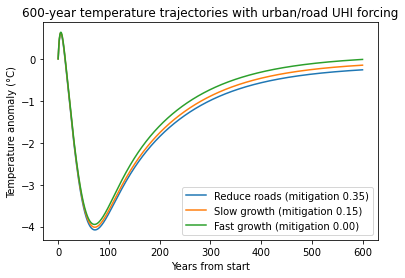

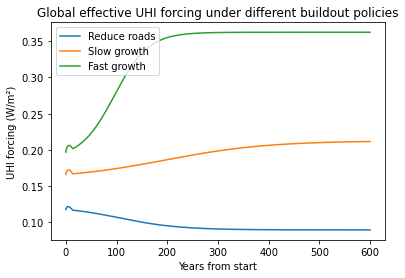

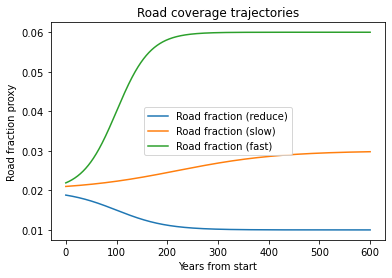

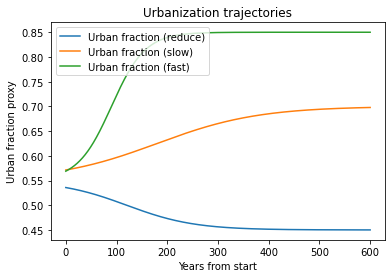

In [14]:
# Run the three policy scenarios over 600 years, and also show a mitigation variant.
years = 600
dt = 1/12

reduce_roads = simulate_ecoclimate_dynamic_land_with_uhi(years=years, dt=dt, scenario="reduce_roads", mitigation=0.35)
slow_growth  = simulate_ecoclimate_dynamic_land_with_uhi(years=years, dt=dt, scenario="slow_growth",  mitigation=0.15)
fast_growth  = simulate_ecoclimate_dynamic_land_with_uhi(years=years, dt=dt, scenario="fast_growth",  mitigation=0.00)

t = slow_growth["t_years"]

plt.figure()
plt.plot(t, reduce_roads["T_mixed_C"], label="Reduce roads (mitigation 0.35)")
plt.plot(t, slow_growth["T_mixed_C"],  label="Slow growth (mitigation 0.15)")
plt.plot(t, fast_growth["T_mixed_C"],  label="Fast growth (mitigation 0.00)")
plt.xlabel("Years from start")
plt.ylabel("Temperature anomaly (°C)")
plt.title("600-year temperature trajectories with urban/road UHI forcing")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, reduce_roads["F_uhi_Wm2"], label="Reduce roads")
plt.plot(t, slow_growth["F_uhi_Wm2"],  label="Slow growth")
plt.plot(t, fast_growth["F_uhi_Wm2"],  label="Fast growth")
plt.xlabel("Years from start")
plt.ylabel("UHI forcing (W/m²)")
plt.title("Global effective UHI forcing under different buildout policies")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, reduce_roads["RoadFrac"], label="Road fraction (reduce)")
plt.plot(t, slow_growth["RoadFrac"],  label="Road fraction (slow)")
plt.plot(t, fast_growth["RoadFrac"],  label="Road fraction (fast)")
plt.xlabel("Years from start")
plt.ylabel("Road fraction proxy")
plt.title("Road coverage trajectories")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, reduce_roads["UrbanFrac"], label="Urban fraction (reduce)")
plt.plot(t, slow_growth["UrbanFrac"],  label="Urban fraction (slow)")
plt.plot(t, fast_growth["UrbanFrac"],  label="Urban fraction (fast)")
plt.xlabel("Years from start")
plt.ylabel("Urban fraction proxy")
plt.title("Urbanization trajectories")
plt.legend()
plt.show()


In [15]:
def land_biosphere_fluxes_with_imperviousness(
    CO2_ppm, T, B, S, impervious_frac,
    CO2_ref=280.0,
    NPP0=60.0,              # GtC/yr at reference
    k_turn=0.05,            # 1/yr vegetation turnover to soil
    k_respS=0.02,           # 1/yr soil respiration baseline
    Q10=2.0,
    Tref=0.0,
    CO2_fert_strength=0.35,
    CO2_fert_half_sat=550.0,
    heat_stress_perC=0.02,
    # Imperviousness effects
    npp_land_elasticity=1.0,      # 1.0 => NPP scales ~ (1 - imperv)
    soil_resp_elasticity=0.6,     # soil respiration reduced by imperviousness (less active soil area)
    regen_bonus=0.0               # optional: if roads decline, greening/restoration can add back capacity
):
    """
    Like land_biosphere_fluxes, but built coverage reduces active biosphere area.
    impervious_frac is a proxy in [0,1] for fraction of land rendered nonproductive.
    """

    imperv = np.clip(impervious_frac, 0.0, 0.95)  # avoid pathological zero-area
    active = max(1e-6, 1.0 - imperv)

    # CO2 fertilization (saturating)
    fert = 1.0 + CO2_fert_strength * (CO2_ppm - CO2_ref) / (CO2_ppm - CO2_ref + CO2_fert_half_sat)

    # Temperature penalty for NPP
    heat_penalty = max(0.0, 1.0 - heat_stress_perC * max(T - Tref, 0.0))

    # Imperviousness reduces productive area; regen_bonus can partially compensate (policy-dependent)
    area_factor_npp = np.clip(active ** npp_land_elasticity + regen_bonus, 0.0, 1.2)
    NPP = NPP0 * fert * heat_penalty * area_factor_npp

    # Turnover from vegetation to soil
    litter_to_soil = k_turn * B

    # Soil respiration depends on temperature and active soil area
    temp_factor = Q10 ** ((T - Tref) / 10.0)
    area_factor_resp = np.clip(active ** soil_resp_elasticity, 0.0, 1.0)
    soil_resp = k_respS * S * temp_factor * area_factor_resp

    net_land_flux_to_atm = soil_resp - NPP
    return NPP, litter_to_soil, soil_resp, net_land_flux_to_atm


In [16]:
def simulate_ecoclimate_dynamic_land_uhi_imperv(
    years=600,
    dt=1/12,
    scenario="slow_growth",
    mitigation=0.0,

    emissions_CO2_func=None,

    # CO2 / ocean / leak
    C0_ppm=280.0,
    C_init_ppm=420.0,
    airborne_base=0.45,
    tau_atm=120.0,
    ocean_sink_0=2.3,
    ocean_k=0.015,
    ocean_T_supp=0.02,

    # Climate core
    F2x=3.7,
    F_nonCO2_constant=0.0,
    C_m=8.0,
    C_d=100.0,
    lambda_clim=1.1,
    kappa=0.65,
    Tm0=0.0,
    Td0=0.0,

    # Land stocks (GtC)
    B0=600.0,
    S0=1500.0,

    # Built-to-impervious mapping
    imperv_base=0.02,      # baseline impervious fraction proxy (not literal)
    imperv_u_scale=0.06,   # urban contribution scaling
    imperv_r_scale=2.0,    # road contribution scaling (roads fragment/displace outsized)
    regen_bonus=0.0,       # restoration bonus for NPP area factor

    # Land parameters for flux function
    land_params=None,

    # UHI forcing parameters
    alpha_u=0.25,
    alpha_r=2.5,
    heat_amplify_perC=0.06
):
    if emissions_CO2_func is None:
        def emissions_CO2_func(t_year):
            peak = 40.0
            t_peak = 20.0
            decline_tau = 60.0
            if t_year <= t_peak:
                return peak * (t_year / t_peak)
            else:
                return peak * np.exp(-(t_year - t_peak)/decline_tau)

    if land_params is None:
        land_params = {}

    ppm_to_GtCO2 = 7.77
    GtCO2_to_ppm = 1.0 / ppm_to_GtCO2
    GtCO2_per_GtC = 3.667

    n = int(years / dt) + 1
    t = np.linspace(0, years, n)

    # Policy trajectories
    urban_frac, road_frac = road_urban_trajectories(t, scenario=scenario)

    # Imperviousness proxy from built fractions
    imperv = np.clip(imperv_base + imperv_u_scale * urban_frac + imperv_r_scale * road_frac, 0.0, 0.30)

    CO2_ppm = np.zeros(n)
    Tm = np.zeros(n)
    Td = np.zeros(n)
    B = np.zeros(n)
    S = np.zeros(n)

    E = np.zeros(n)
    ocean_sink = np.zeros(n)
    leak_sink = np.zeros(n)

    NPP = np.zeros(n)
    soil_resp = np.zeros(n)
    net_land_flux_to_atm_GtCO2 = np.zeros(n)

    F_co2 = np.zeros(n)
    F_uhi = np.zeros(n)
    F_total = np.zeros(n)

    CO2_ppm[0] = C_init_ppm
    Tm[0] = Tm0
    Td[0] = Td0
    B[0] = B0
    S[0] = S0

    for i in range(n-1):
        ti = t[i]
        E[i] = emissions_CO2_func(ti)

        F_co2[i] = F2x * np.log(CO2_ppm[i] / C0_ppm) / np.log(2.0)

        # Land fluxes with imperviousness
        NPP_i, litter_i, soil_resp_i, net_land_to_atm_GtC = land_biosphere_fluxes_with_imperviousness(
            CO2_ppm=CO2_ppm[i],
            T=Tm[i],
            B=B[i],
            S=S[i],
            impervious_frac=imperv[i],
            CO2_ref=C0_ppm,
            regen_bonus=regen_bonus,
            **land_params
        )
        NPP[i] = NPP_i
        soil_resp[i] = soil_resp_i

        B[i+1] = max(0.0, B[i] + (NPP_i - litter_i) * dt)
        S[i+1] = max(0.0, S[i] + (litter_i - soil_resp_i) * dt)

        net_land_flux_to_atm_GtCO2[i] = net_land_to_atm_GtC * GtCO2_per_GtC

        # Ocean + leak
        dC = CO2_ppm[i] - C0_ppm
        warm_supp = max(0.0, 1.0 - ocean_T_supp * max(Tm[i], 0.0))
        ocean_i = (ocean_sink_0 + (ocean_k * dC * ppm_to_GtCO2)) * warm_supp
        ocean_sink[i] = ocean_i
        leak_i = (dC * ppm_to_GtCO2) / tau_atm
        leak_sink[i] = leak_i

        dM_atm = airborne_base * E[i] + net_land_flux_to_atm_GtCO2[i] - ocean_i - leak_i
        CO2_ppm[i+1] = max(1e-6, CO2_ppm[i] + (dM_atm * GtCO2_to_ppm) * dt)

        # UHI forcing
        F_uhi[i] = uhi_forcing_Wm2(
            urban_frac=urban_frac[i],
            road_frac=road_frac[i],
            Tm=Tm[i],
            alpha_u=alpha_u,
            alpha_r=alpha_r,
            heat_amplify_perC=heat_amplify_perC,
            mitigation=mitigation
        )

        F_total[i] = F_co2[i] + F_uhi[i] + F_nonCO2_constant

        dTm = (F_total[i] - lambda_clim * Tm[i] - kappa * (Tm[i] - Td[i])) / C_m
        dTd = (kappa * (Tm[i] - Td[i])) / C_d
        Tm[i+1] = Tm[i] + dTm * dt
        Td[i+1] = Td[i] + dTd * dt

    # last point fill
    E[-1] = emissions_CO2_func(t[-1])
    F_co2[-1] = F2x * np.log(CO2_ppm[-1] / C0_ppm) / np.log(2.0)
    F_uhi[-1] = uhi_forcing_Wm2(urban_frac[-1], road_frac[-1], Tm[-1],
                               alpha_u=alpha_u, alpha_r=alpha_r,
                               heat_amplify_perC=heat_amplify_perC,
                               mitigation=mitigation)
    F_total[-1] = F_co2[-1] + F_uhi[-1] + F_nonCO2_constant

    return {
        "t_years": t,
        "CO2_ppm": CO2_ppm,
        "T_mixed_C": Tm,
        "T_deep_C": Td,
        "B_veg_GtC": B,
        "S_soil_GtC": S,
        "Emissions_GtCO2yr": E,
        "OceanSink_GtCO2yr": ocean_sink,
        "LeakSink_GtCO2yr": leak_sink,
        "NPP_GtCyr": NPP,
        "SoilResp_GtCyr": soil_resp,
        "NetLandFluxToAtm_GtCO2yr": net_land_flux_to_atm_GtCO2,
        "UrbanFrac": urban_frac,
        "RoadFrac": road_frac,
        "ImperviousFrac": imperv,
        "F_co2_Wm2": F_co2,
        "F_uhi_Wm2": F_uhi,
        "F_total_Wm2": F_total,
        "scenario": scenario,
        "mitigation": mitigation,
        "regen_bonus": regen_bonus
    }


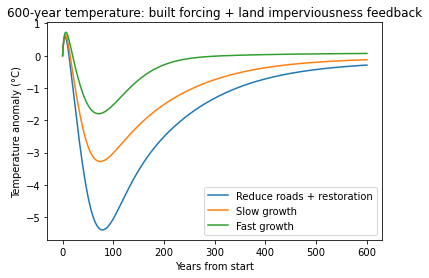

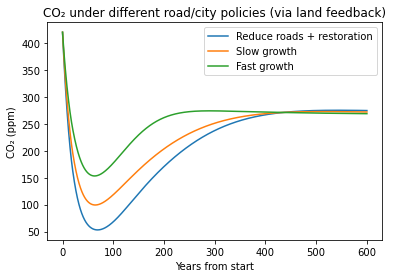

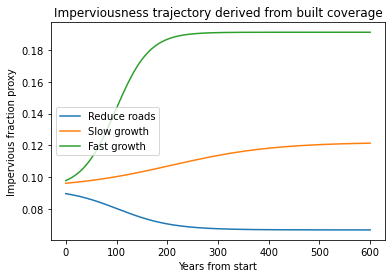

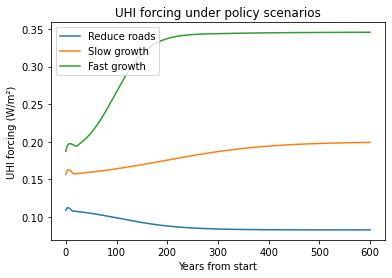

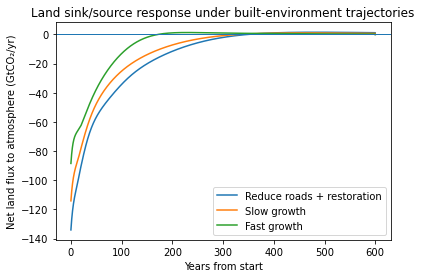

In [17]:
# Three policies: reduce roads (with restoration), slow growth, fast growth.
years = 600
dt = 1/12

reduce_roads = simulate_ecoclimate_dynamic_land_uhi_imperv(
    years=years, dt=dt,
    scenario="reduce_roads",
    mitigation=0.40,
    regen_bonus=0.10,  # restoration / depaving / rewilding
    land_params=dict(Q10=2.1, k_respS=0.02, heat_stress_perC=0.018)
)

slow_growth = simulate_ecoclimate_dynamic_land_uhi_imperv(
    years=years, dt=dt,
    scenario="slow_growth",
    mitigation=0.20,
    regen_bonus=0.02
)

fast_growth = simulate_ecoclimate_dynamic_land_uhi_imperv(
    years=years, dt=dt,
    scenario="fast_growth",
    mitigation=0.05,
    regen_bonus=0.0,
    land_params=dict(Q10=2.3, k_respS=0.024, heat_stress_perC=0.020)
)

t = slow_growth["t_years"]

plt.figure()
plt.plot(t, reduce_roads["T_mixed_C"], label="Reduce roads + restoration")
plt.plot(t, slow_growth["T_mixed_C"], label="Slow growth")
plt.plot(t, fast_growth["T_mixed_C"], label="Fast growth")
plt.xlabel("Years from start")
plt.ylabel("Temperature anomaly (°C)")
plt.title("600-year temperature: built forcing + land imperviousness feedback")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, reduce_roads["CO2_ppm"], label="Reduce roads + restoration")
plt.plot(t, slow_growth["CO2_ppm"], label="Slow growth")
plt.plot(t, fast_growth["CO2_ppm"], label="Fast growth")
plt.xlabel("Years from start")
plt.ylabel("CO₂ (ppm)")
plt.title("CO₂ under different road/city policies (via land feedback)")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, reduce_roads["ImperviousFrac"], label="Reduce roads")
plt.plot(t, slow_growth["ImperviousFrac"], label="Slow growth")
plt.plot(t, fast_growth["ImperviousFrac"], label="Fast growth")
plt.xlabel("Years from start")
plt.ylabel("Impervious fraction proxy")
plt.title("Imperviousness trajectory derived from built coverage")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, reduce_roads["F_uhi_Wm2"], label="Reduce roads")
plt.plot(t, slow_growth["F_uhi_Wm2"], label="Slow growth")
plt.plot(t, fast_growth["F_uhi_Wm2"], label="Fast growth")
plt.xlabel("Years from start")
plt.ylabel("UHI forcing (W/m²)")
plt.title("UHI forcing under policy scenarios")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, reduce_roads["NetLandFluxToAtm_GtCO2yr"], label="Reduce roads + restoration")
plt.plot(t, slow_growth["NetLandFluxToAtm_GtCO2yr"], label="Slow growth")
plt.plot(t, fast_growth["NetLandFluxToAtm_GtCO2yr"], label="Fast growth")
plt.axhline(0, linewidth=1)
plt.xlabel("Years from start")
plt.ylabel("Net land flux to atmosphere (GtCO₂/yr)")
plt.title("Land sink/source response under built-environment trajectories")
plt.legend()
plt.show()


In [21]:
# Sensitivity sweep: vary the buildout "takeoff speed" continuously
# by adjusting the logistic steepness parameters and compare final-century warming.

def road_urban_custom(t, u0=0.55, u1=0.80, r0=0.02, r1=0.05, t_mid=120, k=0.02):
    u = logistic_transition(t, u0, u1, t_mid, k)
    r = logistic_transition(t, r0, r1, t_mid, k)
    return np.clip(u,0,1), np.clip(r,0,1)

def simulate_with_custom_takeoff(k_takeoff):
    # Patch in custom trajectories by temporarily overriding road_urban_trajectories logic.
    years=600; dt=1/12
    n = int(years/dt)+1
    t = np.linspace(0, years, n)
    u, r = road_urban_custom(t, u0=0.55, u1=0.85, r0=0.02, r1=0.06, t_mid=100, k=k_takeoff)

    out = simulate_ecoclimate_dynamic_land_uhi_imperv(
        years=years, dt=dt,
        scenario="slow_growth",  
        mitigation=0.10,
        regen_bonus=0.0
    )
  
    return out


In [22]:
def simulate_ecoclimate_with_exogenous_build(
    t_years,
    urban_frac,
    road_frac,
    dt,
    mitigation=0.0,
    regen_bonus=0.0,

    emissions_CO2_func=None,

    # CO2 / ocean / leak
    C0_ppm=280.0,
    C_init_ppm=420.0,
    airborne_base=0.45,
    tau_atm=120.0,
    ocean_sink_0=2.3,
    ocean_k=0.015,
    ocean_T_supp=0.02,

    # Climate core
    F2x=3.7,
    F_nonCO2_constant=0.0,
    C_m=8.0,
    C_d=100.0,
    lambda_clim=1.1,
    kappa=0.65,
    Tm0=0.0,
    Td0=0.0,

    # Land stocks
    B0=600.0,
    S0=1500.0,

    # Impervious mapping
    imperv_base=0.02,
    imperv_u_scale=0.06,
    imperv_r_scale=2.0,

    # Land parameters
    land_params=None,

    # UHI forcing
    alpha_u=0.25,
    alpha_r=2.5,
    heat_amplify_perC=0.06
):
    if emissions_CO2_func is None:
        def emissions_CO2_func(t_year):
            peak = 40.0
            t_peak = 20.0
            decline_tau = 60.0
            if t_year <= t_peak:
                return peak * (t_year / t_peak)
            else:
                return peak * np.exp(-(t_year - t_peak)/decline_tau)

    if land_params is None:
        land_params = {}

    ppm_to_GtCO2 = 7.77
    GtCO2_to_ppm = 1.0 / ppm_to_GtCO2
    GtCO2_per_GtC = 3.667

    n = len(t_years)

    CO2_ppm = np.zeros(n)
    Tm = np.zeros(n)
    Td = np.zeros(n)
    B = np.zeros(n)
    S = np.zeros(n)

    F_co2 = np.zeros(n)
    F_uhi = np.zeros(n)
    F_total = np.zeros(n)

    imperv = np.clip(
        imperv_base + imperv_u_scale * urban_frac + imperv_r_scale * road_frac,
        0.0, 0.30
    )

    CO2_ppm[0] = C_init_ppm
    Tm[0] = Tm0
    Td[0] = Td0
    B[0] = B0
    S[0] = S0

    for i in range(n-1):
        t = t_years[i]
        E = emissions_CO2_func(t)

        F_co2[i] = F2x * np.log(CO2_ppm[i] / C0_ppm) / np.log(2.0)

        NPP_i, litter_i, soil_resp_i, net_land_to_atm_GtC = (
            land_biosphere_fluxes_with_imperviousness(
                CO2_ppm=CO2_ppm[i],
                T=Tm[i],
                B=B[i],
                S=S[i],
                impervious_frac=imperv[i],
                CO2_ref=C0_ppm,
                regen_bonus=regen_bonus,
                **land_params
            )
        )

        B[i+1] = max(0.0, B[i] + (NPP_i - litter_i) * dt)
        S[i+1] = max(0.0, S[i] + (litter_i - soil_resp_i) * dt)

        net_land_flux_GtCO2 = net_land_to_atm_GtC * GtCO2_per_GtC

        dC = CO2_ppm[i] - C0_ppm
        ocean_sink = (ocean_sink_0 + ocean_k * dC * ppm_to_GtCO2) * \
                      max(0.0, 1.0 - ocean_T_supp * max(Tm[i], 0.0))
        leak = (dC * ppm_to_GtCO2) / tau_atm

        dM_atm = airborne_base * E + net_land_flux_GtCO2 - ocean_sink - leak
        CO2_ppm[i+1] = max(1e-6, CO2_ppm[i] + dM_atm * GtCO2_to_ppm * dt)

        F_uhi[i] = uhi_forcing_Wm2(
            urban_frac[i], road_frac[i], Tm[i],
            alpha_u=alpha_u,
            alpha_r=alpha_r,
            heat_amplify_perC=heat_amplify_perC,
            mitigation=mitigation
        )

        F_total[i] = F_co2[i] + F_uhi[i] + F_nonCO2_constant

        dTm = (F_total[i] - lambda_clim * Tm[i] - kappa * (Tm[i] - Td[i])) / C_m
        dTd = (kappa * (Tm[i] - Td[i])) / C_d
        Tm[i+1] = Tm[i] + dTm * dt
        Td[i+1] = Td[i] + dTd * dt

    F_co2[-1] = F2x * np.log(CO2_ppm[-1] / C0_ppm) / np.log(2.0)
    F_uhi[-1] = uhi_forcing_Wm2(
        urban_frac[-1], road_frac[-1], Tm[-1],
        alpha_u=alpha_u, alpha_r=alpha_r,
        heat_amplify_perC=heat_amplify_perC,
        mitigation=mitigation
    )
    F_total[-1] = F_co2[-1] + F_uhi[-1] + F_nonCO2_constant

    return {
        "t_years": t_years,
        "CO2_ppm": CO2_ppm,
        "T_mixed_C": Tm,
        "T_deep_C": Td,
        "B_veg_GtC": B,
        "S_soil_GtC": S,
        "UrbanFrac": urban_frac,
        "RoadFrac": road_frac,
        "ImperviousFrac": imperv,
        "F_co2_Wm2": F_co2,
        "F_uhi_Wm2": F_uhi,
        "F_total_Wm2": F_total
    }


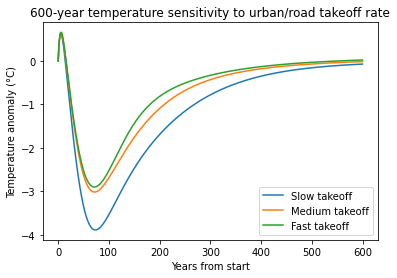

In [23]:
# Example: three explicit takeoff rates using the same model core

years = 600
dt = 1/12
t = np.linspace(0, years, int(years/dt) + 1)

def build_trajectory(k):
    u = logistic_transition(t, 0.55, 0.85, t_mid=100, k=k)
    r = logistic_transition(t, 0.02, 0.06, t_mid=100, k=k)
    return u, r

urban_slow, road_slow = build_trajectory(0.008)
urban_mid,  road_mid  = build_trajectory(0.020)
urban_fast, road_fast = build_trajectory(0.050)

out_slow = simulate_ecoclimate_with_exogenous_build(
    t, urban_slow, road_slow, dt,
    mitigation=0.30, regen_bonus=0.08
)

out_mid = simulate_ecoclimate_with_exogenous_build(
    t, urban_mid, road_mid, dt,
    mitigation=0.15, regen_bonus=0.02
)

out_fast = simulate_ecoclimate_with_exogenous_build(
    t, urban_fast, road_fast, dt,
    mitigation=0.05, regen_bonus=0.0
)

plt.figure()
plt.plot(t, out_slow["T_mixed_C"], label="Slow takeoff")
plt.plot(t, out_mid["T_mixed_C"], label="Medium takeoff")
plt.plot(t, out_fast["T_mixed_C"], label="Fast takeoff")
plt.xlabel("Years from start")
plt.ylabel("Temperature anomaly (°C)")
plt.title("600-year temperature sensitivity to urban/road takeoff rate")
plt.legend()
plt.show()


## References

Hansen, J., Lacis, A., Rind, D., Russell, G., Stone, P., Fung, I., Ruedy, R., and Lerner, J. (1984). Climate sensitivity: Analysis of feedback mechanisms. *Geophysical Monograph Series*, 29, 130–163.

Geoffroy, O., Saint-Martin, D., Bellon, G., Voldoire, A., Olivié, D., and Tytéca, S. (2013). Transient climate response in a two-layer energy-balance model. *Journal of Climate*, 26(6), 1841–1857.

Myhre, G., Highwood, E. J., Shine, K. P., and Stordal, F. (1998). New estimates of radiative forcing due to well mixed greenhouse gases. *Geophysical Research Letters*, 25(14), 2715–2718.

Friedlingstein, P., Meinshausen, M., Arora, V. K., Jones, C. D., Anav, A., Liddicoat, S. K., and Knutti, R. (2014). Uncertainties in CMIP5 climate projections due to carbon cycle feedbacks. *Journal of Climate*, 27(2), 511–526.

Ciais, P., Sabine, C., Bala, G., Bopp, L., Brovkin, V., Canadell, J., Chhabra, A., et al. (2013). Carbon and other biogeochemical cycles. In *Climate Change 2013: The Physical Science Basis*. IPCC Working Group I.

Parton, W. J., Schimel, D. S., Cole, C. V., and Ojima, D. S. (1987). Analysis of factors controlling soil organic matter levels in Great Plains grasslands. *Soil Science Society of America Journal*, 51(5), 1173–1179.

Lloyd, J., and Taylor, J. A. (1994). On the temperature dependence of soil respiration. *Functional Ecology*, 8(3), 315–323.

Seto, K. C., Güneralp, B., and Hutyra, L. R. (2012). Global forecasts of urban expansion to 2030 and direct impacts on biodiversity and carbon pools. *Proceedings of the National Academy of Sciences of the United States of America*, 109(40), 16083–16088.

Oke, T. R. (1982). The energetic basis of the urban heat island. *Quarterly Journal of the Royal Meteorological Society*, 108(455), 1–24.

Zhao, L., Lee, X., Smith, R. B., and Oleson, K. (2014). Strong contributions of local background climate to urban heat islands. *Nature*, 511, 216–219.

Creutzig, F., Agoston, P., Goldschmidt, J. C., Luderer, G., Nemet, G., and Pietzcker, R. C. (2017). The underestimated potential of solar energy to mitigate climate change. *Nature Energy*, 2, 17140.

Prather, M. J., and Wilson, C. P. (2026). Projecting nitrous oxide over the 21st century: Uncertainty related to stratospheric loss. *Proceedings of the National Academy of Sciences of the United States of America*, 123(6), e2524123123. https://doi.org/10.1073/pnas.2524123123

Batty, M. (2013). *The New Science of Cities*. MIT Press.

Angel, S., Parent, J., Civco, D. L., Blei, A., and Potere, D. (2011). The dimensions of global urban expansion: Estimates and projections for all countries, 2000–2050. *Progress in Planning*, 75(2), 53–107.
